#### Import Library

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

2025-01-07 06:26:03.975589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736231163.990582   20509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736231163.995173   20509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 06:26:04.015168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Load Dataset

In [2]:
maindf = pd.read_csv("/workspaces/codespaces-jupyter/data/BTC-USD.csv")

In [3]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2713
Total number of fields present in the dataset:  7


In [4]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [5]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2708,2022-02-15,42586.464844,44667.218750,42491.035156,44575.203125,44575.203125,22721659051
2709,2022-02-16,44578.277344,44578.277344,43456.691406,43961.859375,43961.859375,19792547657
2710,2022-02-17,43937.070313,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2711,2022-02-18,40552.132813,40929.152344,39637.617188,40030.976563,40030.976563,23310007704
2712,2022-02-19,40022.132813,40246.027344,40010.867188,40126.429688,40126.429688,22263900160


In [6]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


In [7]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2713.000000,2713.000000,2713.000000,2713.000000,2713.000000,2.713000e+03
mean,11311.041069,11614.292482,10975.555057,11323.914637,11323.914637,1.470462e+10
std,16106.428891,16537.390649,15608.572560,16110.365010,16110.365010,2.001627e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,606.396973,609.260986,604.109985,606.718994,606.718994,7.991080e+07
50%,6301.569824,6434.617676,6214.220215,6317.609863,6317.609863,5.098183e+09
75%,10452.399414,10762.644531,10202.387695,10462.259766,10462.259766,2.456992e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


#### Check NULL values

In [8]:
print("Null Values: ", maindf.isnull().values.sum())

Null Values:  0


In [9]:
print('NA values:',maindf.isnull().values.any())

NA values: False


#### EDA (Explore Data Analysis)

In [10]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2014-09-17
Ending Date 2022-02-19


/tmp/ipykernel_20509/1210088768.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd=maindf.iloc[0][0]
/tmp/ipykernel_20509/1210088768.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ed=maindf.iloc[-1][0]


In [11]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2014 = maindf.loc[(maindf['Date'] >= '2014-09-17')
                    & (maindf['Date'] < '2014-12-31')]

y_2014.drop(y_2014[['Adj Close', 'Volume']], axis=1)

,Date,Open,High,Low,Close
0,2014-09-17,465.864014,468.174011,452.421997,457.334015
1,2014-09-18,456.859985,456.859985,413.104004,424.440002
2,2014-09-19,424.102997,427.834991,384.532013,394.795990
3,2014-09-20,394.673004,423.295990,389.882996,408.903992
4,2014-09-21,408.084991,412.425995,393.181000,398.821014
...,...,...,...,...,...
100,2014-12-26,319.152008,331.424011,316.627014,327.924011
101,2014-12-27,327.583008,328.911011,312.630005,315.863007
102,2014-12-28,316.160004,320.028015,311.078003,317.239014
103,2014-12-29,317.700989,320.266998,312.307007,312.670013


In [12]:
monthvise= y_2014.groupby(y_2014['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,NaN,NaN
February,NaN,NaN
March,NaN,NaN
April,NaN,NaN
May,NaN,NaN
June,NaN,NaN
July,NaN,NaN
August,NaN,NaN
September,412.654003,407.182428


In [18]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson',
    text=monthvise['Open'],  # Menambahkan nilai
    textposition='inside'   # Menampilkan nilai di luar batang
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='blue',
    text=monthvise['Close'],  # Menambahkan nilai
    textposition='inside'    # Menampilkan nilai di luar batang
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparison between Stock open and close price')
fig.show()

In [21]:
y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_high = y_2014.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthvise_high = monthvise_high.reindex(new_order, axis=0)

monthvise_low = y_2014.groupby(y_2014['Date'].dt.strftime('%B'))['Low'].min()
monthvise_low = monthvise_low.reindex(new_order, axis=0)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthvise_high.index,
    y=monthvise_high,
    name='Stock high Price',
    marker_color='rgb(0, 153, 204)',
    text=monthvise_high,  # Menambahkan nilai
    textposition='inside'  # Menampilkan nilai di luar batang
))
fig.add_trace(go.Bar(
    x=monthvise_low.index,
    y=monthvise_low,
    name='Stock low Price',
    marker_color='rgb(255, 128, 0)',
    text=monthvise_low,  # Menambahkan nilai
    textposition='inside'  # Menampilkan nilai di luar batang
))

fig.update_layout(barmode='group', 
                  title='Monthwise High and Low stock price')
fig.show()

In [23]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])
#names adalah iterator yang akan mengulang nama-nama parameter saham yang berbeda.

fig = px.line(y_2014, x=y_2014.Date, y=[y_2014['Open'], y_2014['Close'], 
                                          y_2014['High'], y_2014['Low']], #menentukan sumbu y sebagai daftar kolom yang berisi nilai saham.
             labels={'Date': 'Date','value':'Stock value'})


fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
# update_layout digunakan untuk memperbarui tata letak grafik.
# title_text menetapkan judul grafik.
# font_size dan font_color menetapkan ukuran dan warna font.
# legend_title_text menetapkan judul legenda.

fig.for_each_trace(lambda t:  t.update(name = next(names)))
# for_each_trace digunakan untuk iterasi melalui setiap trace dalam grafik.
# lambda t: t.update(name=next(names)) memperbarui nama setiap trace dengan nama dari iterator names.

fig.update_xaxes(showgrid=False) #update_xaxes dan update_yaxes digunakan untuk memperbarui sumbu x dan y.
fig.update_yaxes(showgrid=False) #showgrid=False menghilangkan grid pada sumbu x dan y.

fig.show()

#### Analysis 2015

In [24]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d') #Mengonversi Kolom 'Date' ke Tipe Datetime

y_2015 = maindf.loc[(maindf['Date'] >= '2015-01-01')
                     & (maindf['Date'] < '2016-01-01')] #filter data untuk tanggal antara 1 Januari 2015 dan 31 Desember 2015.

y_2015.drop(y_2015[['Adj Close','Volume']],axis=1)
# drop digunakan untuk menghapus kolom atau baris dari DataFrame.
# y_2015[['Adj Close', 'Volume']] menunjukkan kolom yang akan dihapus.
# axis=1 menunjukkan bahwa kolom yang akan dihapus, bukan baris.

,Date,Open,High,Low,Close
106,2015-01-01,320.434998,320.434998,314.002991,314.248993
107,2015-01-02,314.079010,315.838989,313.565002,315.032013
108,2015-01-03,314.846008,315.149994,281.082001,281.082001
109,2015-01-04,281.145996,287.230011,257.612000,264.195007
110,2015-01-05,265.084015,278.341003,265.084015,274.473999
...,...,...,...,...,...
466,2015-12-27,416.514008,424.006989,408.882996,422.822998
467,2015-12-28,423.342987,429.769012,418.480988,422.278992
468,2015-12-29,422.097992,432.983002,420.627014,432.983002
469,2015-12-30,433.299988,434.386993,422.084015,426.619995


In [25]:
monthvise= y_2015.groupby(y_2015['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,251.799905,248.782547
February,232.821856,234.153645
March,269.278419,269.042259
April,235.708667,235.491534
May,237.161806,236.997001
June,236.941433,238.081766
July,278.857679,279.563740
August,252.986774,250.733805
September,233.486733,233.595533


In [38]:
volatility = y_2015[['Open', 'High', 'Low', 'Close']].std()
print(volatility)

Open     58.736787
High     61.344046
Low      56.767289
Close    59.337860
dtype: float64


In [39]:
correlation_matrix = y_2015[['Open', 'High', 'Low', 'Close']].corr()
print(correlation_matrix)

           Open      High       Low     Close
Open   1.000000  0.989604  0.989943  0.985570
High   0.989604  1.000000  0.982302  0.989326
Low    0.989943  0.982302  1.000000  0.994890
Close  0.985570  0.989326  0.994890  1.000000


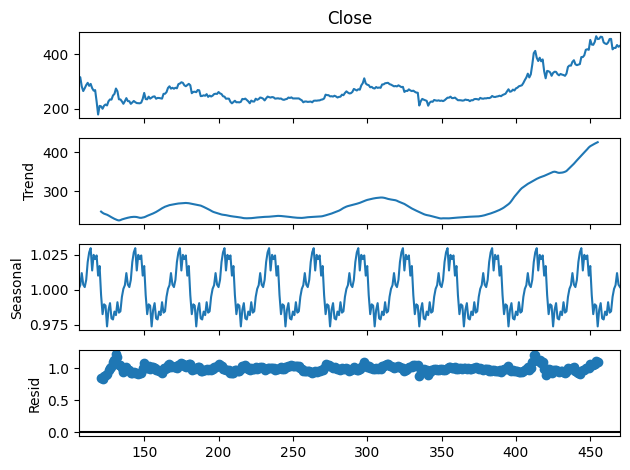

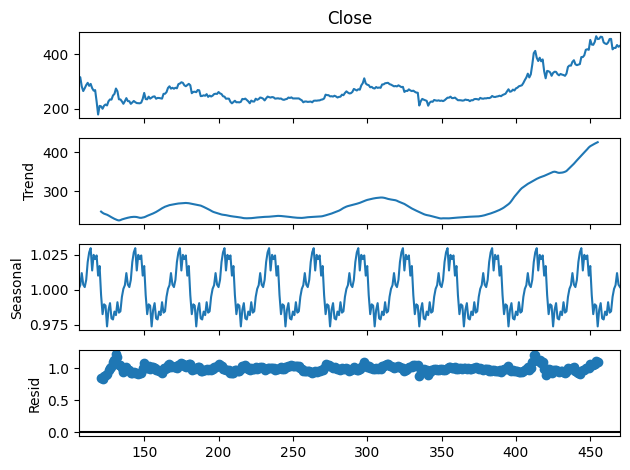

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(y_2015['Close'], model='multiplicative', period=30)
decomposition.plot()

In [36]:
fig = go.Figure(data=[go.Candlestick(x=y_2015['Date'],
                                     open=y_2015['Open'],
                                     high=y_2015['High'],
                                     low=y_2015['Low'],
                                     close=y_2015['Close'])])

fig.update_layout(title='Bitcoin Candlestick Chart for 2015', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [27]:
fig = go.Figure()

fig.add_trace(go.Bar( #add_trace digunakan untuk menambahkan trace baru ke dalam figure & go.Bar digunakan untuk membuat diagram batang.
    x=monthvise.index, #menentukan sumbu x sebagai indeks dari DataFrame monthvise.
    y=monthvise['Open'], #menentukan sumbu y sebagai nilai dari kolom Open dalam DataFrame
    name='Stock Open Price',
    marker_color='crimson',
    text=monthvise['Open'],  # Menambahkan nilai
    textposition='inside'   # Menampilkan nilai di luar batang
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='salmon',
    text=monthvise['Close'],  # Menambahkan nilai
    textposition='inside'    # Menampilkan nilai di luar batang
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparison between Stock open and close price')
# update_layout digunakan untuk memperbarui tata letak grafik.
# barmode='group' mengatur mode batang menjadi grup, sehingga batang untuk harga buka dan tutup akan dikelompokkan bersama.
# xaxis_tickangle=-45 mengatur sudut rotasi label sumbu x menjadi -45 derajat.
# title='Monthwise comparison between Stock open and close price' menetapkan judul grafik.

fig.show()

In [28]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], 
                                          y_2015['High'], y_2015['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

In [34]:
from itertools import cycle
import plotly.express as px
import plotly.graph_objects as go

names = cycle(['Stock Open Price', 'Stock Close Price', 'Stock High Price', 'Stock Low Price'])

fig = px.line(y_2015, x=y_2015.Date, y=[y_2015['Open'], y_2015['Close'], y_2015['High'], y_2015['Low']],
              labels={'Date': 'Date', 'value': 'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black', legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Menambahkan garis tren
fig.add_traces([
    go.Scatter(x=y_2015.Date, y=y_2015['Open'].rolling(window=30).mean(), mode='lines', name='Open Trend', line=dict(dash='dash')),
    go.Scatter(x=y_2015.Date, y=y_2015['Close'].rolling(window=30).mean(), mode='lines', name='Close Trend', line=dict(dash='dash')),
    go.Scatter(x=y_2015.Date, y=y_2015['High'].rolling(window=30).mean(), mode='lines', name='High Trend', line=dict(dash='dash')),
    go.Scatter(x=y_2015.Date, y=y_2015['Low'].rolling(window=30).mean(), mode='lines', name='Low Trend', line=dict(dash='dash'))
])

# Menambahkan anotasi
fig.add_annotation(x='2015-06-01', y=y_2015['High'].max(),
                   text="Highest Point",
                   showarrow=True,
                   arrowhead=1)

# Mengubah tema grafik
fig.update_layout(template='plotly_white')

# Menambahkan hover info
fig.update_traces(mode='lines+markers', hovertemplate='Date: %{x}<br>Value: %{y}')

# Menambahkan slider dan range selector
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung koefisien korelasi antara kolom Open, High, Low, dan Close
correlation_matrix = y_2015[['Open', 'High', 'Low', 'Close']].corr()

# Cetak matriks korelasi
print(correlation_matrix)

           Open      High       Low     Close
Open   1.000000  0.989604  0.989943  0.985570
High   0.989604  1.000000  0.982302  0.989326
Low    0.989943  0.982302  1.000000  0.994890
Close  0.985570  0.989326  0.994890  1.000000


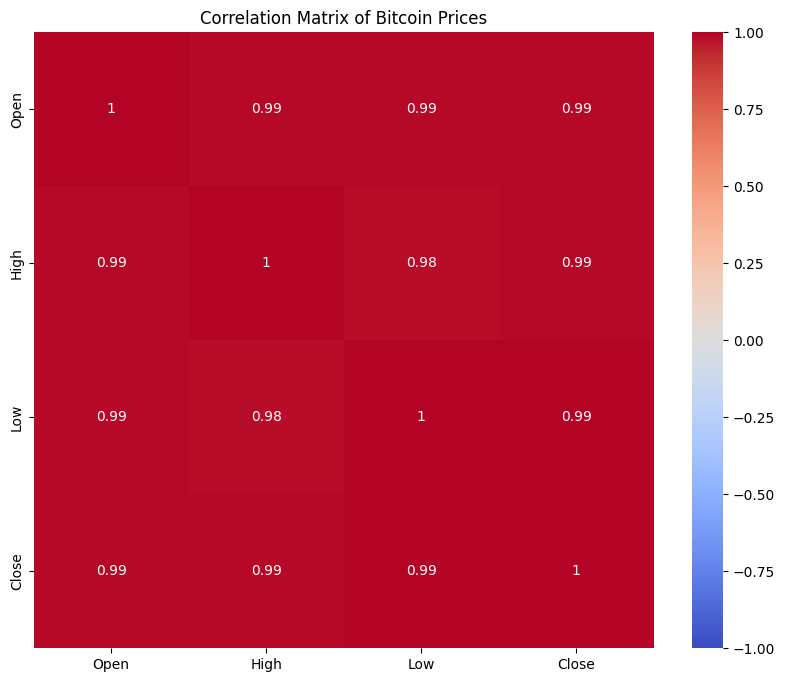

In [43]:
# Visualisasikan matriks korelasi menggunakan heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Bitcoin Prices')
plt.show()

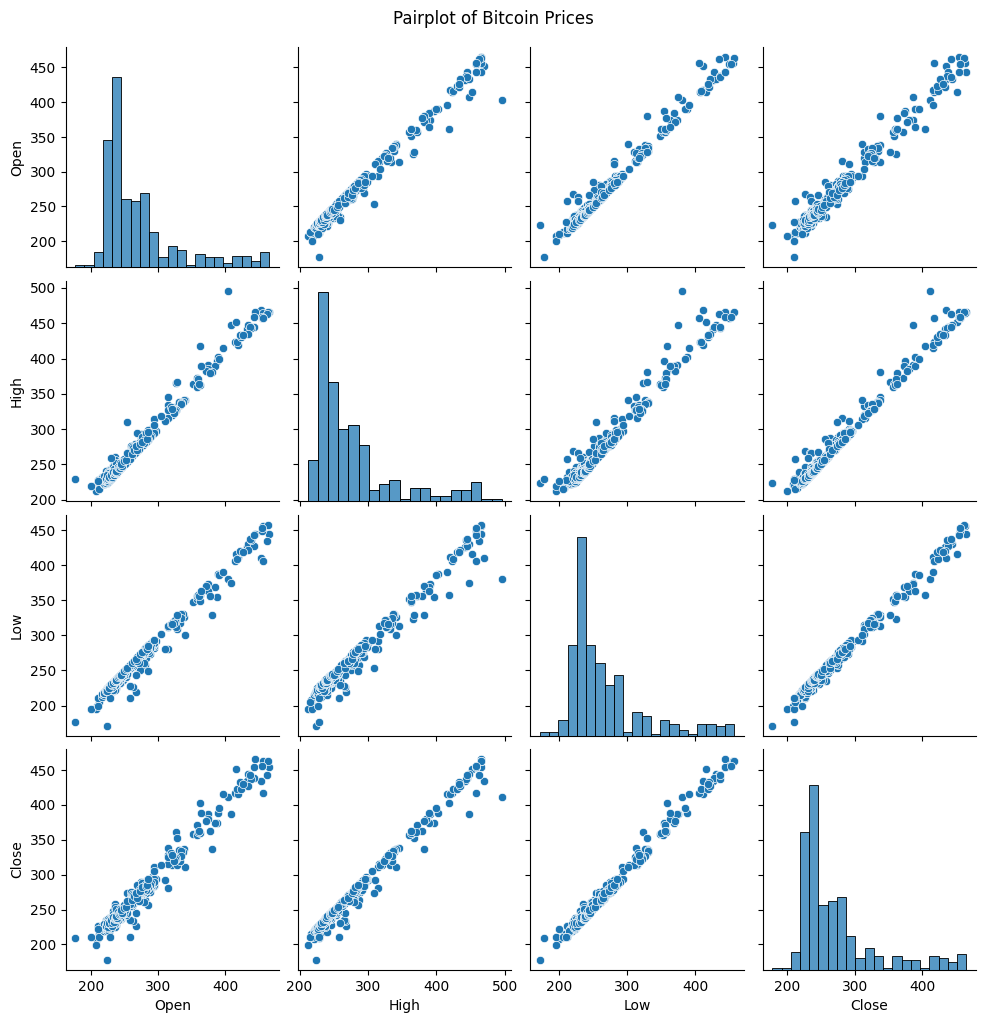

In [44]:
# Analisis lebih mendalam
# Scatter plot untuk melihat hubungan antara pasangan kolom
sns.pairplot(y_2015[['Open', 'High', 'Low', 'Close']])
plt.suptitle('Pairplot of Bitcoin Prices', y=1.02)
plt.show()
